# 오버워치 2 점수판 분석 AI

In [1]:
import os
import pandas as pd

players = 10


def prepare_scoreboards(defeat_, draw_, victory_):
    scoreboards_ = pd.concat([defeat_, draw_, victory_])
    scoreboards_.set_index(
        pd.Index((i, j) for i in range(len(scoreboards_.index) // players) for j in range(players)), inplace=True
    )
    return scoreboards_


datapath = os.path.join('datasets', '')
range_ = range(3, 10)
defeat = pd.read_csv(datapath + 'defeat.csv', usecols=range_)
draw = pd.read_csv(datapath + 'draw.csv', usecols=range_)
victory = pd.read_csv(datapath + 'victory.csv', usecols=range_)
scoreboards = prepare_scoreboards(defeat, draw, victory)
scoreboards.loc[
    (
            scoreboards['E'] == 0
    ) & (
            scoreboards['A'] == 0
    ) & (
            scoreboards['D'] == 0
    ) & (
            scoreboards['DMG'] == 0
    ) & (
            scoreboards['H'] == 0
    ) & (
            scoreboards['MIT'] == 0
    ), 'D'
] = scoreboards['D'].max()
scoreboards

E  A   D   DMG     H   MIT    GAME
0   0   7  3   6  5933  1068  6199  DEFEAT
    1   7  0  10  3601   747     0  DEFEAT
    2   9  1   6  4352     0     0  DEFEAT
    3   7  7   2  2332  6325     0  DEFEAT
    4   6  4   2  3410  5979   606  DEFEAT
...    .. ..  ..   ...   ...   ...     ...
264 5   9  1   8  7168    27  3499  DEFEAT
    6  13  7   5  5146  1696     0  DEFEAT
    7  13  0   9  8192  1156     0  DEFEAT
    8   6  9   8  3180  9243   463  DEFEAT
    9   6  6   7  1926  6251   362  DEFEAT

[2650 rows x 7 columns]

In [2]:
scoreboards.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 2650 entries, (0, 0) to (264, 9)
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   E       2650 non-null   int64 
 1   A       2650 non-null   int64 
 2   D       2650 non-null   int64 
 3   DMG     2650 non-null   int64 
 4   H       2650 non-null   int64 
 5   MIT     2650 non-null   int64 
 6   GAME    2650 non-null   object
dtypes: int64(6), object(1)
memory usage: 163.3+ KB


In [3]:
scoreboards.describe()

,E,A,D,DMG,H,MIT
count,2650.000000,2650.000000,2650.000000,2650.000000,2650.000000,2650.000000
mean,13.843774,7.369811,6.544906,6242.400000,3868.690189,2311.350566
std,10.365013,8.739197,4.113213,4672.140995,5168.560594,4666.699524
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,6.000000,1.000000,3.000000,2644.500000,0.000000,0.000000
50%,12.000000,4.000000,6.000000,5304.000000,801.000000,245.000000
75%,20.000000,12.000000,9.000000,9234.000000,7358.000000,1671.250000
max,56.000000,48.000000,21.000000,29354.000000,27756.000000,41092.000000


In [4]:
import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)
IMAGES_PATH = os.path.join('.', 'images')
os.makedirs(IMAGES_PATH, exist_ok=True)


def save_fig(fig_id, tight_layout=True, fig_extension='png', resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + '.' + fig_extension)
    print('그림 저장:' + fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, dpi=resolution, format=fig_extension)

In [5]:
tank = scoreboards[::players]
damage = pd.concat([scoreboards[1::players], scoreboards[2::players]])
support = pd.concat([scoreboards[3::players], scoreboards[4::players]])

그림 저장:tank_hist


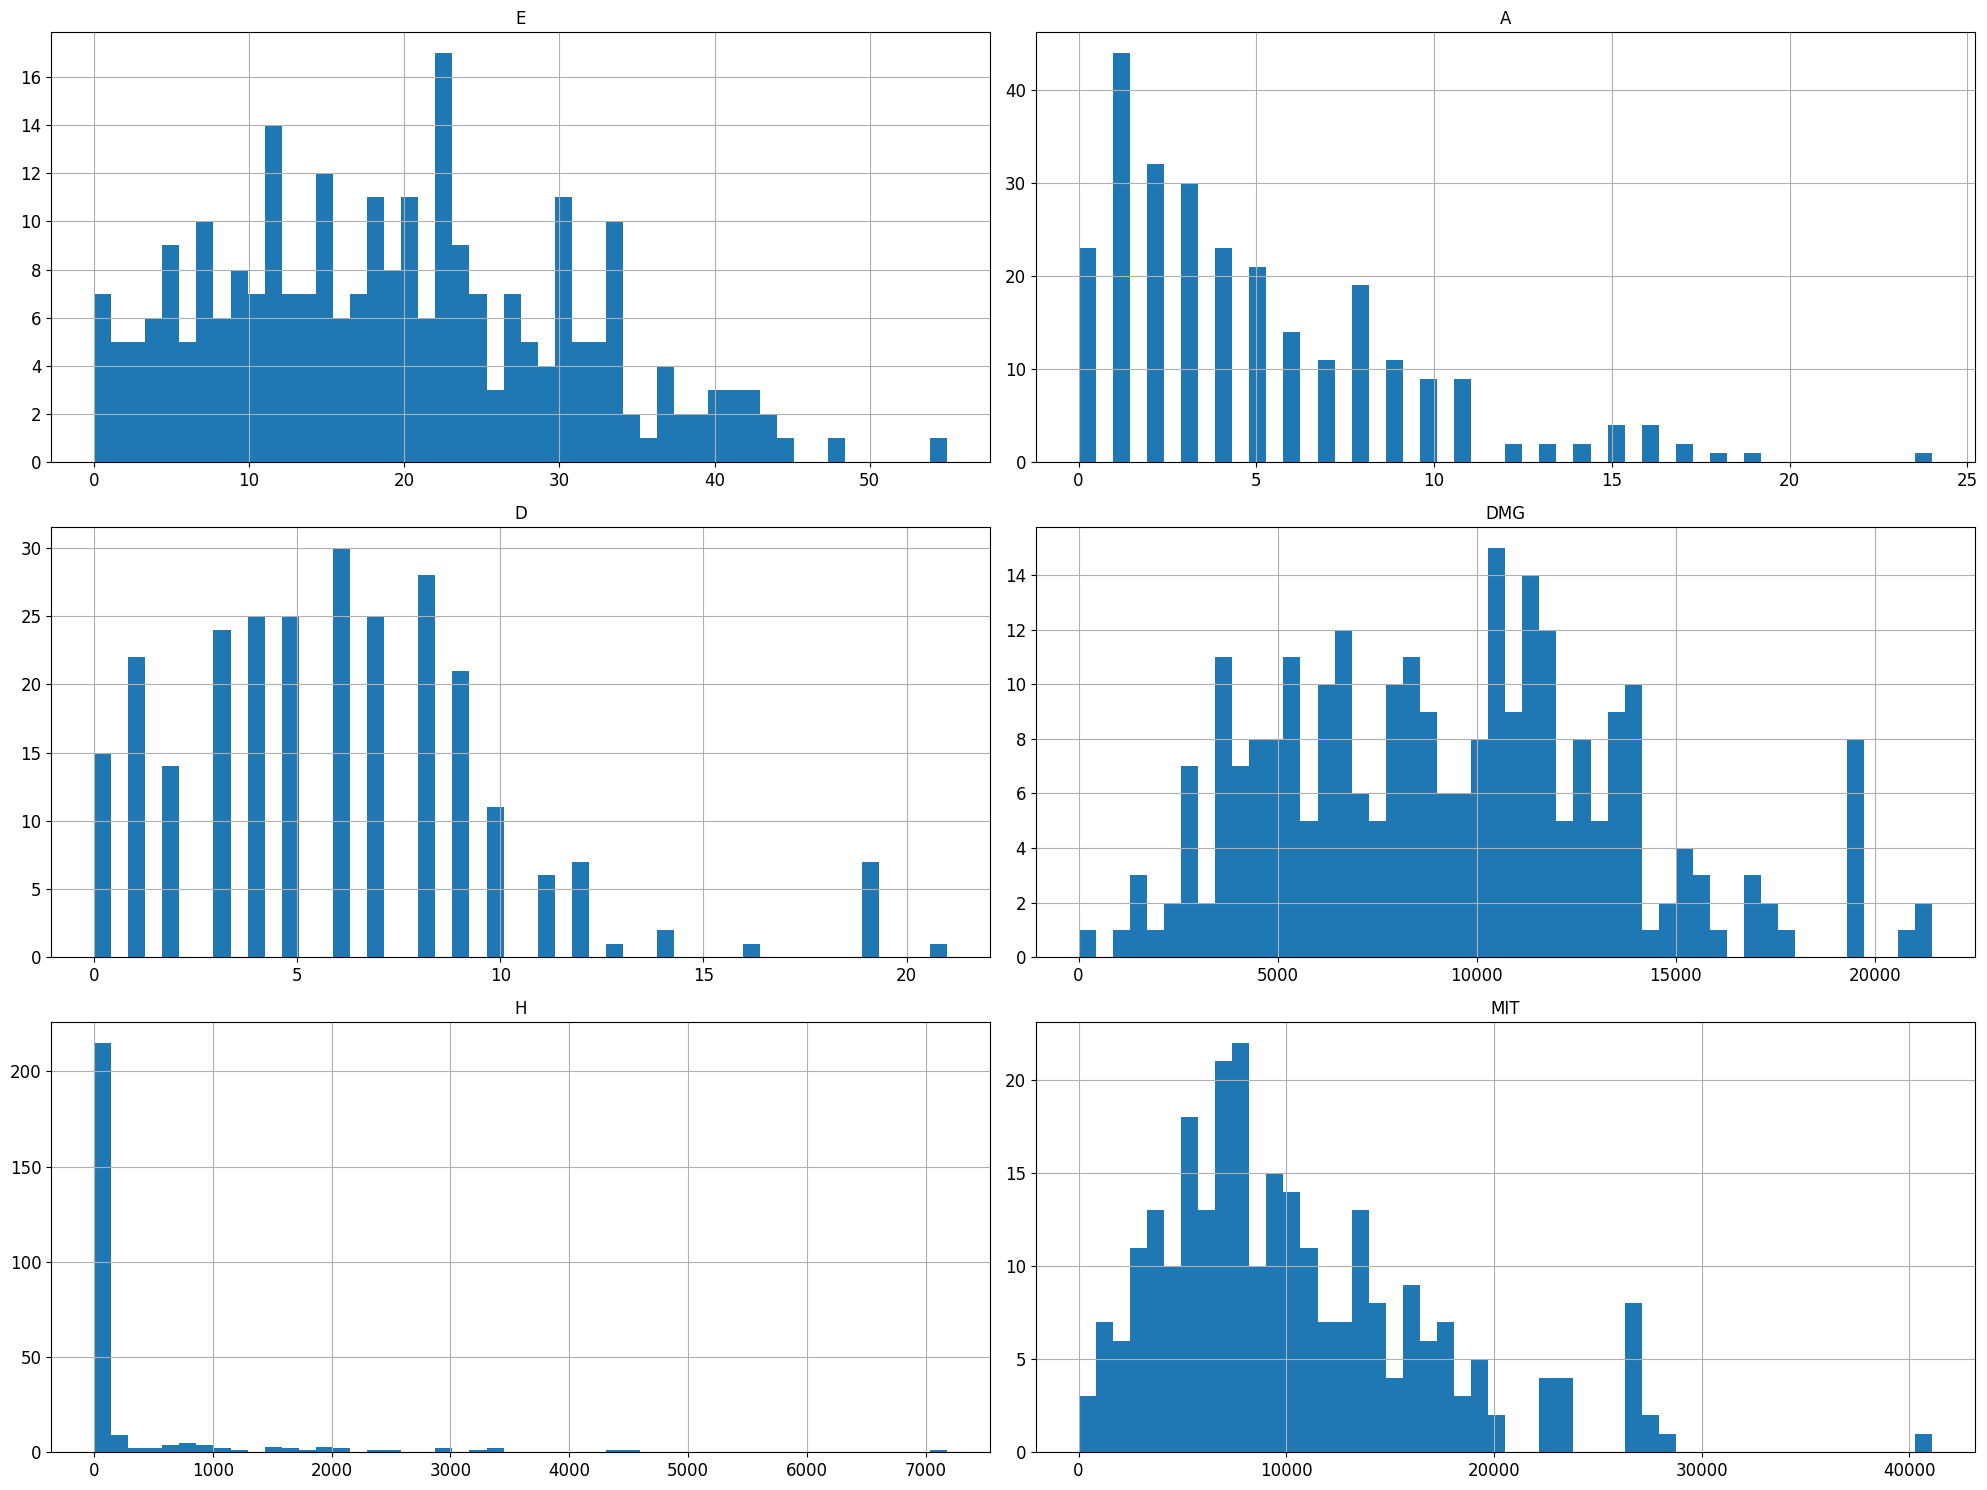

In [6]:
tank.hist(bins=50, figsize=(20, 15))
save_fig('tank_hist')
plt.show()

그림 저장:damage_hist


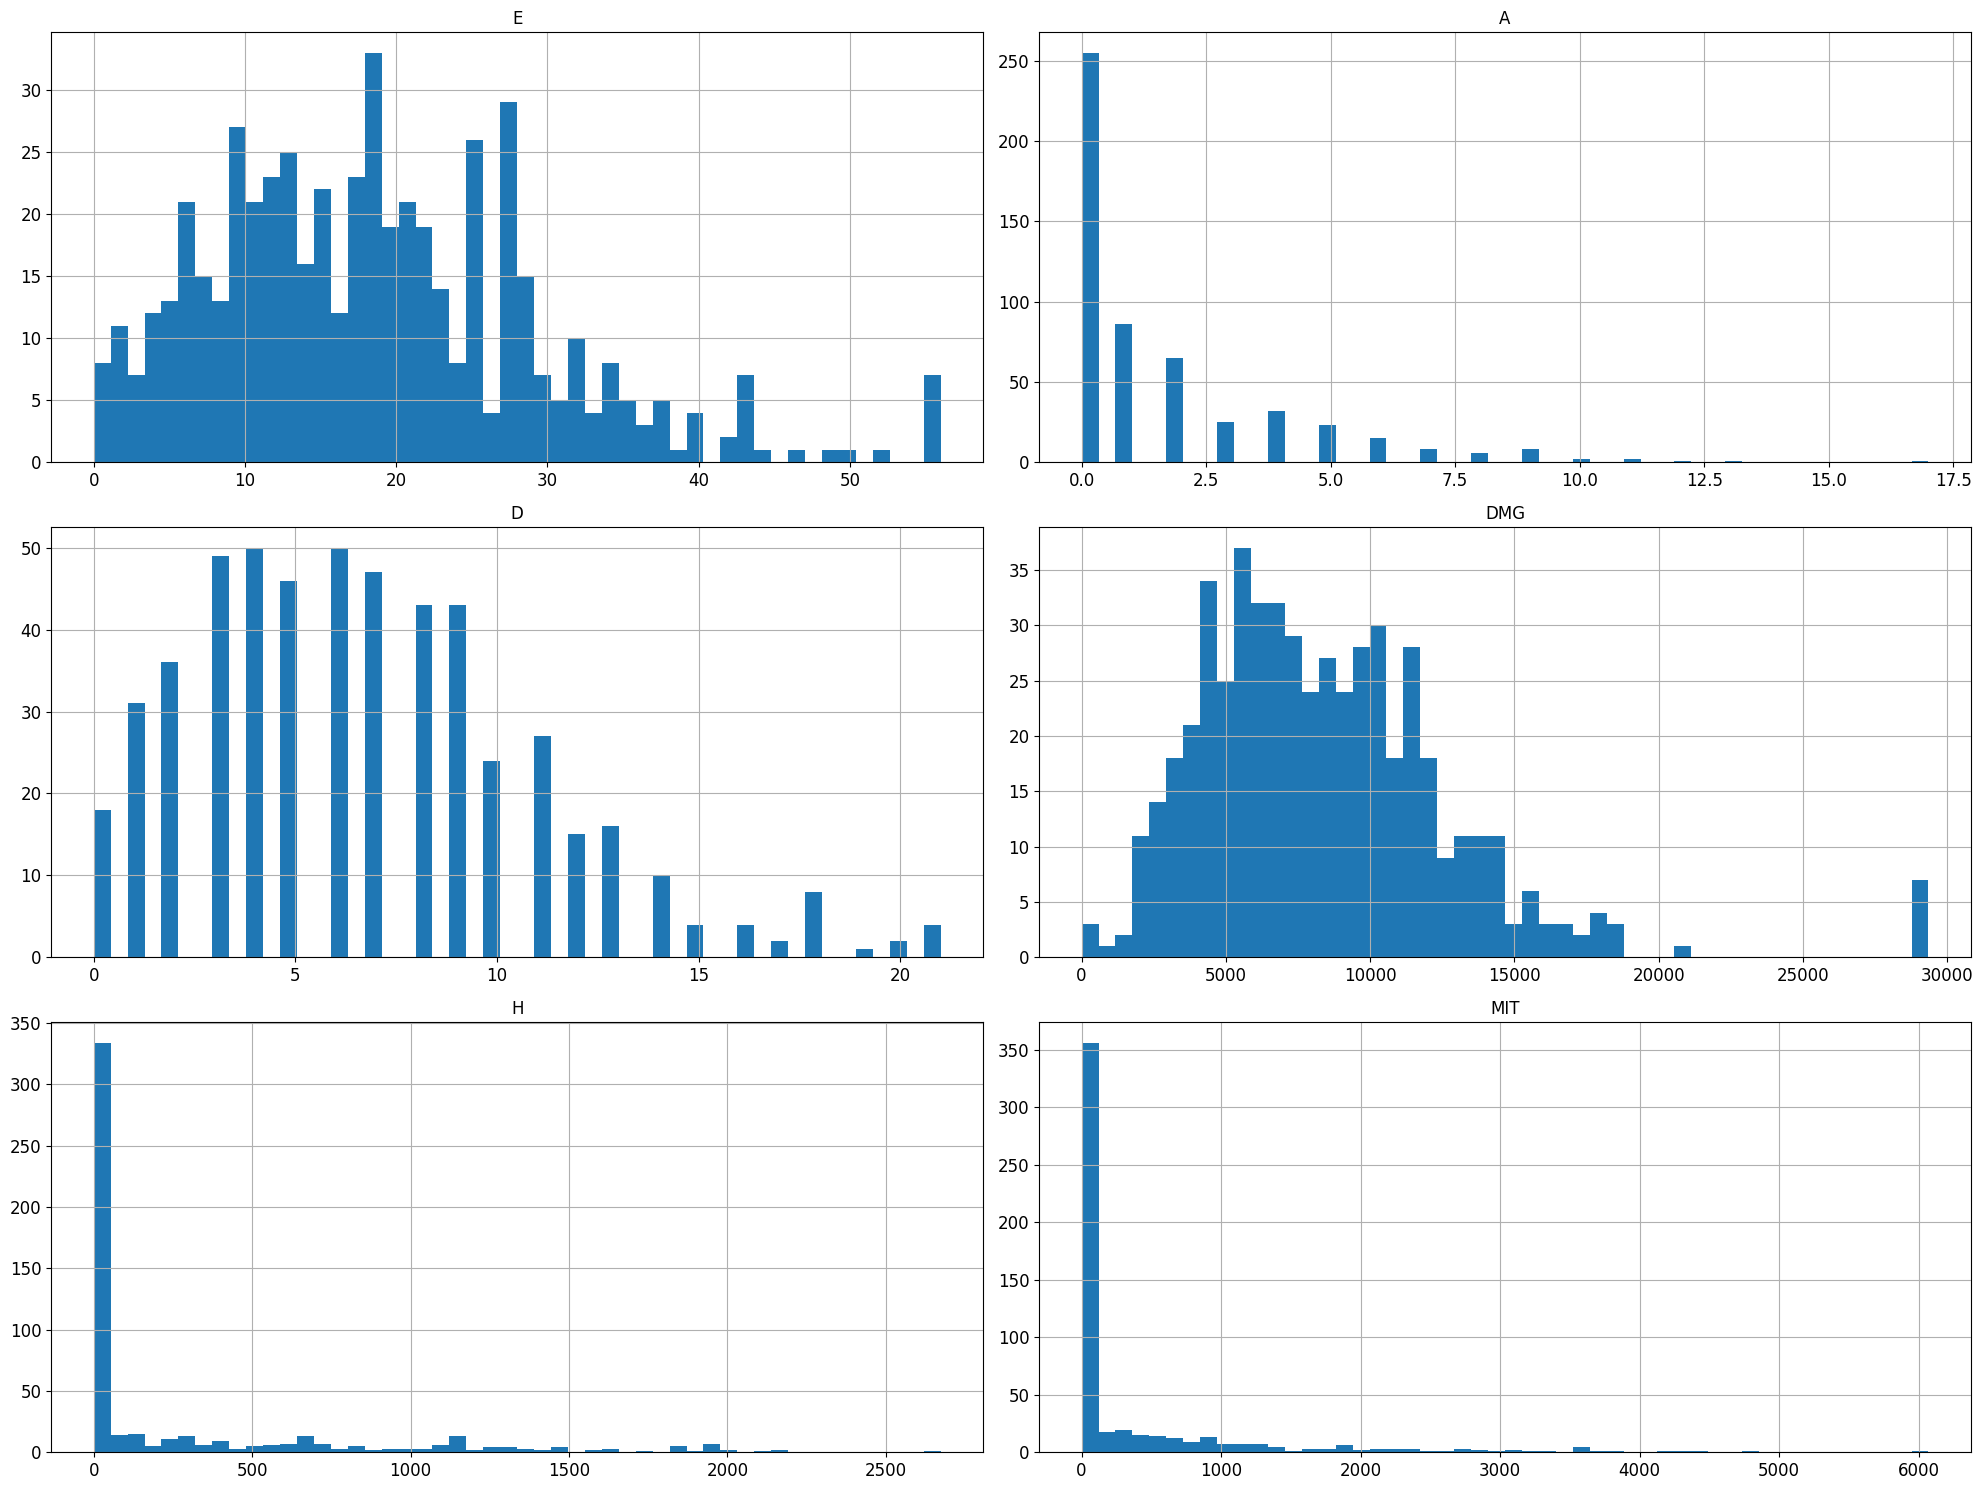

In [7]:
damage.hist(bins=50, figsize=(20, 15))
save_fig('damage_hist')
plt.show()

그림 저장:support_hist


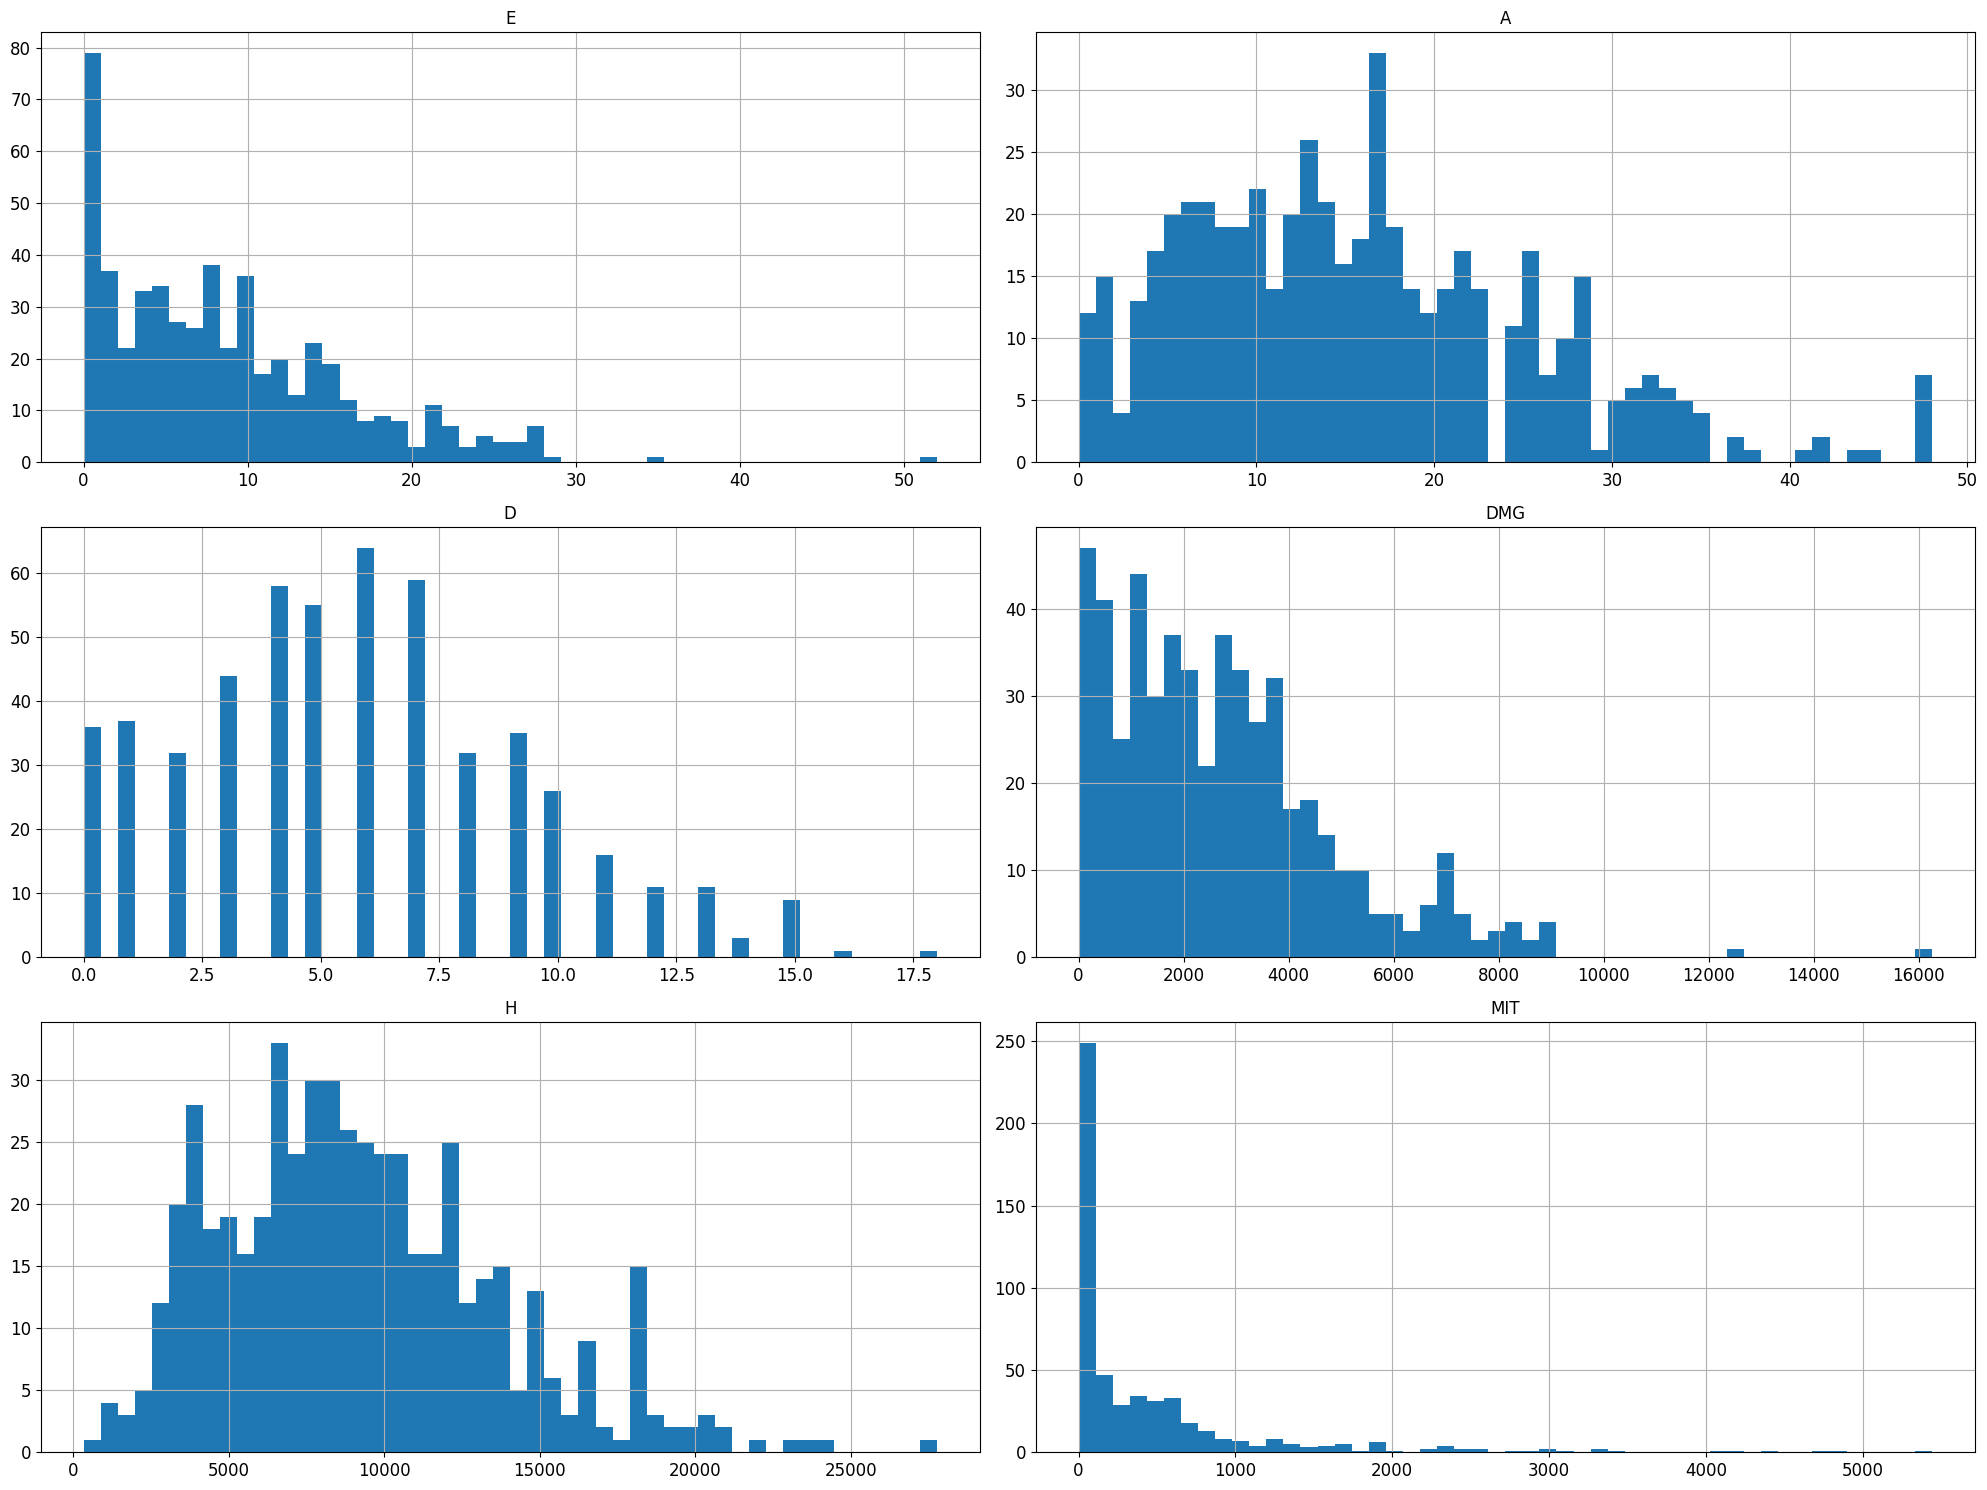

In [8]:
support.hist(bins=50, figsize=(20, 15))
save_fig('support_hist')
plt.show()

In [9]:
from sklearn.utils import shuffle

index = scoreboards.index
train_set = scoreboards.loc[shuffle(range(len(index) // players))]
train_set

E   A  D    DMG      H   MIT     GAME
223 0  14   1  6   8105      0  8910  VICTORY
    1  15   0  1   4804      0     0  VICTORY
    2  15   4  7   7444    108   932  VICTORY
    3  14  13  1   3964   9579   768  VICTORY
    4  13  11  3   4155   9261   442  VICTORY
...    ..  .. ..    ...    ...   ...      ...
49  5  18   4  3  10038   2350  4296  VICTORY
    6  16   8  3  11127    765     0  VICTORY
    7  16   2  3   7653      0   220  VICTORY
    8   6  16  1   1914   9529    75  VICTORY
    9   0  18  2     12  13371  1012  VICTORY

[2650 rows x 7 columns]

In [10]:
scoreboards = train_set.drop('GAME', axis=1)
scoreboards_labels = train_set['GAME'].copy()

In [11]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
X = scaler.fit_transform(scoreboards)
scoreboards_tr = pd.DataFrame(X, index, scoreboards.columns)
scoreboards_tr

E         A         D       DMG         H       MIT
0   0  0.250000  0.020833  0.285714  0.276112  0.000000  0.216831
    1  0.267857  0.000000  0.047619  0.163657  0.000000  0.000000
    2  0.267857  0.083333  0.333333  0.253594  0.003891  0.022681
    3  0.250000  0.270833  0.047619  0.135041  0.345115  0.018690
    4  0.232143  0.229167  0.142857  0.141548  0.333658  0.010756
...         ...       ...       ...       ...       ...       ...
264 5  0.321429  0.083333  0.142857  0.341964  0.084666  0.104546
    6  0.285714  0.166667  0.142857  0.379062  0.027562  0.000000
    7  0.285714  0.041667  0.142857  0.260714  0.000000  0.005354
    8  0.107143  0.333333  0.047619  0.065204  0.343313  0.001825
    9  0.000000  0.375000  0.095238  0.000409  0.481734  0.024628

[2650 rows x 6 columns]

In [12]:
features = X.shape[-1]
X = X.reshape(-1, players * features)
X.shape

(265, 60)

In [13]:
y = scoreboards_labels[::players]
y.shape

(265,)

In [14]:
from sklearn import ensemble, linear_model, neighbors, neural_network, svm, tree
from sklearn.model_selection import cross_val_score
from operator import itemgetter

estimators = (
    ensemble.AdaBoostClassifier(),
    ensemble.BaggingClassifier(n_jobs=-1),
    ensemble.ExtraTreesClassifier(n_jobs=-1),
    ensemble.GradientBoostingClassifier(),
    ensemble.RandomForestClassifier(n_jobs=-1),
    ensemble.HistGradientBoostingClassifier(),
    linear_model.LogisticRegression(n_jobs=-1),
    linear_model.LogisticRegressionCV(max_iter=400, n_jobs=-1),
    linear_model.PassiveAggressiveClassifier(n_jobs=-1),
    linear_model.Perceptron(n_jobs=-1),
    linear_model.RidgeClassifier(),
    linear_model.RidgeClassifierCV(),
    linear_model.SGDClassifier(n_jobs=-1),
    neighbors.KNeighborsClassifier(n_jobs=-1),
    neighbors.RadiusNeighborsClassifier(2., n_jobs=-1),
    neighbors.NearestCentroid(),
    neural_network.MLPClassifier(max_iter=2000),
    svm.LinearSVC(dual='auto'),
    svm.NuSVC(nu=.09),
    svm.SVC(),
    tree.DecisionTreeClassifier(),
    tree.ExtraTreeClassifier()
)
scores = [(estimator, cross_val_score(estimator, X, y, n_jobs=-1).mean()) for estimator in estimators]
scores.sort(key=itemgetter(1), reverse=True)
scores

[(SVC(), 0.9132075471698113),
 (RandomForestClassifier(n_jobs=-1), 0.8981132075471698),
 (LogisticRegression(n_jobs=-1), 0.8981132075471698),
 (MLPClassifier(max_iter=2000), 0.8981132075471698),
 (ExtraTreesClassifier(n_jobs=-1), 0.8943396226415095),
 (RidgeClassifier(), 0.8905660377358492),
 (RidgeClassifierCV(), 0.8905660377358492),
 (GradientBoostingClassifier(), 0.8905660377358491),
 (NearestCentroid(), 0.8905660377358491),
 (LinearSVC(dual='auto'), 0.8905660377358491),
 (LogisticRegressionCV(max_iter=400, n_jobs=-1), 0.8867924528301888),
 (Perceptron(n_jobs=-1), 0.8830188679245283),
 (KNeighborsClassifier(n_jobs=-1), 0.8830188679245283),
 (HistGradientBoostingClassifier(), 0.879245283018868),
 (PassiveAggressiveClassifier(n_jobs=-1), 0.879245283018868),
 (SGDClassifier(n_jobs=-1), 0.8754716981132077),
 (BaggingClassifier(n_jobs=-1), 0.8716981132075471),
 (NuSVC(nu=0.09), 0.8603773584905661),
 (DecisionTreeClassifier(), 0.781132075471698),
 (ExtraTreeClassifier(), 0.754716981132075

In [15]:
for estimator, _ in scores:
    estimator = estimator.fit(X, y)
    if hasattr(estimator, 'feature_importances_'):
        print(estimator)
        importances = estimator.feature_importances_.reshape(-1, features)
        importances_tanks = importances[[0, 5]].sum(0)
        importances_damages = importances[[1, 2, 6, 7]].sum(0)
        importances_supports = importances[[3, 4, 8, 9]].sum(0)
        importance_tanks = importances_tanks.sum()
        importance_damages = importances_damages.sum()
        importance_supports = importances_supports.sum()

        print('\n**역할 중요도**')
        for importance, title in sorted(
                zip((importance_tanks, importance_damages / 2, importance_supports / 2), ('돌격 1인', '공격 1인', '지원 1인')),
                reverse=True
        ):
            print(f'{title}: {importance * 100:.0f}%')

        titles = '처치', '도움', '죽음', '피해', '치유', '경감'

        print('\n**특성 중요도**')
        for importance, title in sorted(zip(importances.sum(0), titles), reverse=True):
            print(f'{title}: {importance * 100:.0f}%')

        print('\n**돌격 1인 특성 중요도**')
        for importance, title in sorted(zip(importances_tanks, titles), reverse=True):
            print(f'{title}: {importance * 100:.0f}%')

        print('\n**공격 1인 특성 중요도**')
        for importance, title in sorted(zip(importances_damages / 2, titles), reverse=True):
            print(f'{title}: {importance * 100:.0f}%')

        print('\n**지원 1인 특성 중요도**')
        for importance, title in sorted(zip(importances_supports / 2, titles), reverse=True):
            print(f'{title}: {importance * 100:.0f}%')

        break

RandomForestClassifier(n_jobs=-1)

**역할 중요도**
돌격 1인: 30%
공격 1인: 18%
지원 1인: 17%

**특성 중요도**
처치: 31%
죽음: 31%
도움: 17%
피해: 11%
치유: 7%
경감: 5%

**돌격 1인 특성 중요도**
죽음: 14%
처치: 10%
도움: 2%
피해: 2%
경감: 1%
치유: 1%

**공격 1인 특성 중요도**
처치: 8%
죽음: 5%
피해: 3%
치유: 1%
도움: 1%
경감: 1%

**지원 1인 특성 중요도**
도움: 6%
죽음: 4%
처치: 2%
치유: 2%
피해: 1%
경감: 1%


In [16]:
index_1 = 6
index_2 = index_1 * players
scoreboard = scoreboards[index_2:index_2 + players]
scoreboard_index = scoreboard.index[0][0] + 1
defeats = len(defeat) // players
defeats_draws = defeats + len(draw) // players
if scoreboard_index <= defeats:
    print(f'\nDEFEAT: {scoreboard_index}')
elif scoreboard_index <= defeats_draws:
    print(f'\nDRAW: {scoreboard_index - defeats}')
else:
    print(f'\nVICTORY: {scoreboard_index - defeats_draws}')
scoreboard


VICTORY: 100


E   A   D   DMG     H    MIT
235 0  16   3   4  5519     0  12204
    1  19   0   3  4917     0      0
    2  18   1   7  8701   642    139
    3  15  10   6  3058  4570    344
    4   0  21   7     0  8440      0
    5  13   2   9  5554   786   2957
    6  12   0   7  7751  1823     38
    7  16   1   8  6917     0      0
    8   5   7   7  1573  3825    707
    9   0   0  21     0     0      0

In [17]:
scoreboard = X[index_1].reshape(players, features).copy()
scoreboard[:, 2] = 1 - scoreboard[:, 2]
scoreboard[[0, 5]] *= importances_tanks / 2
scoreboard[[1, 2, 6, 7]] *= importances_damages / 4
scoreboard[[3, 4, 8, 9]] *= importances_supports / 4
shares = scoreboard.sum(1)
contributions = shares / scoreboard.sum()
print('**기여도**')
print(f'TEAM 1:', end='')
for contribution in contributions[:5]:
    print(f' {contribution:.2%}', end='')
print(f'\nTEAM 2:', end='')
for contribution in contributions[5:]:
    print(f' {contribution:.2%}', end='')
shares /= ((shares[[0, 5]].sum(),) + (shares[[1, 2, 6, 7]].sum(),) * 2 + (shares[[3, 4, 8, 9]].sum(),) * 2) * 2
shares *= ((2,) + (4,) * 4) * 2
print('\n\n**기여몫**')
print(f'TEAM 1:', end='')
for share in shares[:5]:
    print(f' {share:.2f}', end='')
print(f'\nTEAM 2:', end='')
for share in shares[5:]:
    print(f' {share:.2f}', end='')

**기여도**
TEAM 1: 22.65% 10.68% 9.77% 7.99% 9.06%
TEAM 2: 16.42% 8.44% 8.71% 6.26% 0.00%

**기여몫**
TEAM 1: 1.16 1.14 1.04 1.37 1.55
TEAM 2: 0.84 0.90 0.93 1.07 0.00

In [24]:
scores[0]

(SVC(), 0.9132075471698113)

In [28]:
estimators = [(str(scores[i][0]), scores[i][0]) for i in range(6)]
clf = ensemble.StackingClassifier(estimators, scores[0][0], n_jobs=-1)
cross_val_score(clf, X, y, n_jobs=-1).mean()

0.9132075471698113

In [29]:
estimators

[('SVC()', SVC()),
 ('RandomForestClassifier(n_jobs=-1)', RandomForestClassifier(n_jobs=-1)),
 ('LogisticRegression(n_jobs=-1)', LogisticRegression(n_jobs=-1)),
 ('MLPClassifier(max_iter=2000)', MLPClassifier(max_iter=2000)),
 ('ExtraTreesClassifier(n_jobs=-1)', ExtraTreesClassifier(n_jobs=-1)),
 ('RidgeClassifier()', RidgeClassifier())]